## Imports  

In [44]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer 
import torch
import pandas as pd
from datasets import Dataset, DatasetDict
import seaborn as sns       
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [45]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.1


In [46]:
model_name = "../models/bert_reverse"

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny", return_tensor="pt")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy = evaluate.load("accuracy")

id2label = {0: "CONTROL", 1: "BROCA"}
label2id = {"CONTROL": 0, "BROCA": 1}

model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=2, id2label=id2label, label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
model.config

BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "id2label": {
    "0": "CONTROL",
    "1": "BROCA"
  },
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "label2id": {
    "BROCA": 1,
    "CONTROL": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.39.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [49]:
# dataset_filename = "../../linguistic_model/data/bnc_merge.csv"
dataset_filename = "../../linguistic_model/data/boston_merge.csv"
data = pd.read_csv(dataset_filename, encoding='utf8', index_col=False)#.drop(['Unnamed: 0','predicted'], axis=1)
data = data.dropna(axis=0)

In [50]:
data

,preprocessed_text,label
0,i am a veteran so i do not go to county hospitals,0
1,he is happy he he whole mare herds now,1
2,where are they now i missed that,0
3,under the clinton administration,0
4,could x x,1
...,...,...
16478,or am i mistaken,0
16479,the real long,0
16480,they would do their sentences and then they wo...,0
16481,and how we do it,0


In [51]:
len(data)

16483

In [52]:
# check if there is the same data imbalance ratio
data["label"].value_counts()

label
0    11893
1     4590
Name: count, dtype: int64

In [53]:
dataset = Dataset.from_pandas(data)

In [54]:
dataset

Dataset({
    features: ['preprocessed_text', 'label'],
    num_rows: 16483
})

In [55]:
def compute_metrics(eval_pred):
    metrics = ["accuracy", "recall", "precision", "f1"] #List of metrics to return
    metric={}
    
    for met in metrics:
       metric[met] = evaluate.load(met)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    metrics.extend(["tp", "tn"])
    cm = confusion_matrix(labels, predictions, normalize='true')
    tp, fp, fn, tn = cm.ravel()
    metric_res={}
    for met in metrics:
        if met == "tp":
            metric_res[met] = tp
        elif met == "tn":
            metric_res[met] = tn
        else:
            metric_res[met]=metric[met].compute(predictions=predictions, references=labels)[met]
        
    print(metric_res)
    return metric_res

In [56]:
def preprocess_function(examples):
    return tokenizer(examples["preprocessed_text"], padding=True, truncation=True, return_tensors="pt", max_length=512)

In [57]:
tokenized_data = dataset.map(preprocess_function, batched=True).with_format("torch")

Map:   0%|          | 0/16483 [00:00<?, ? examples/s]

In [58]:
tokenized_data_split = tokenized_data.train_test_split(test_size=0.2, seed=42)

In [59]:
# 70% train, 30% test + valid
train_testvalid = tokenized_data.train_test_split(test_size=0.2, seed=42)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=41)

In [60]:
tokenized_data_split = DatasetDict({
    "train": train_testvalid["train"],
    "test": test_valid["test"],
    "valid": test_valid["train"]})

In [61]:
tokenized_data_split

DatasetDict({
    train: Dataset({
        features: ['preprocessed_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 13186
    })
    test: Dataset({
        features: ['preprocessed_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1649
    })
    valid: Dataset({
        features: ['preprocessed_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1648
    })
})

In [62]:
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16, # 16
    per_device_eval_batch_size=16,  # 16
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=50,
    save_total_limit=5,
    load_best_model_at_end=True,
    push_to_hub=False,
    use_cpu = False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data_split["train"],
    eval_dataset=tokenized_data_split["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5)]
)

trainer.train()
trainer.save_model(model_name)

C:\Users\imruh\miniconda3\envs\thesis\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss


{'accuracy': 0.7252880533656761, 'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'tp': 1.0, 'tn': 0.0}


C:\Users\imruh\miniconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.7252880533656761, 'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'tp': 1.0, 'tn': 0.0}


C:\Users\imruh\miniconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.727107337780473, 'recall': 0.006622516556291391, 'precision': 1.0, 'f1': 0.013157894736842105, 'tp': 1.0, 'tn': 0.006622516556291391}
{'accuracy': 0.7616737416616131, 'recall': 0.15894039735099338, 'precision': 0.8571428571428571, 'f1': 0.2681564245810056, 'tp': 0.9899665551839465, 'tn': 0.15894039735099338}
{'accuracy': 0.7859308671922377, 'recall': 0.31346578366445915, 'precision': 0.7717391304347826, 'f1': 0.44583987441130296, 'tp': 0.9648829431438127, 'tn': 0.31346578366445915}
{'accuracy': 0.7950272892662219, 'recall': 0.4194260485651214, 'precision': 0.7169811320754716, 'f1': 0.5292479108635098, 'tp': 0.9372909698996655, 'tn': 0.4194260485651214}
{'accuracy': 0.7962401455427531, 'recall': 0.4746136865342163, 'precision': 0.6869009584664537, 'f1': 0.5613577023498695, 'tp': 0.9180602006688964, 'tn': 0.4746136865342163}
{'accuracy': 0.7992722862340813, 'recall': 0.5099337748344371, 'precision': 0.6794117647058824, 'f1': 0.5825977301387137, 'tp': 0.9088628762541806, 't

In [63]:
trainer.evaluate()

{'accuracy': 0.821710127349909, 'recall': 0.5938189845474614, 'precision': 0.7097625329815304, 'f1': 0.6466346153846154, 'tp': 0.9080267558528428, 'tn': 0.5938189845474614}


{'eval_loss': 0.3913533389568329,
 'eval_accuracy': 0.821710127349909,
 'eval_recall': 0.5938189845474614,
 'eval_precision': 0.7097625329815304,
 'eval_f1': 0.6466346153846154,
 'eval_tp': 0.9080267558528428,
 'eval_tn': 0.5938189845474614,
 'eval_runtime': 6.3333,
 'eval_samples_per_second': 260.369,
 'eval_steps_per_second': 16.421,
 'epoch': 2.0}

# Evaluate model

In [64]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained(model_name, return_tensor="pt")
model = AutoModelForSequenceClassification.from_pretrained(model_name)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [65]:
sentences = tokenized_data_split["valid"]["preprocessed_text"]
true_labels = tokenized_data_split["valid"]["label"] 

In [66]:
pred_labels = []

for sentence in sentences:
    inputs = tokenizer(sentence, return_tensors="pt").input_ids.to(device) 
    with torch.no_grad():
        logits = model(inputs).logits
    predicted_class_id = logits.argmax().item()
    pred_labels.append(predicted_class_id)

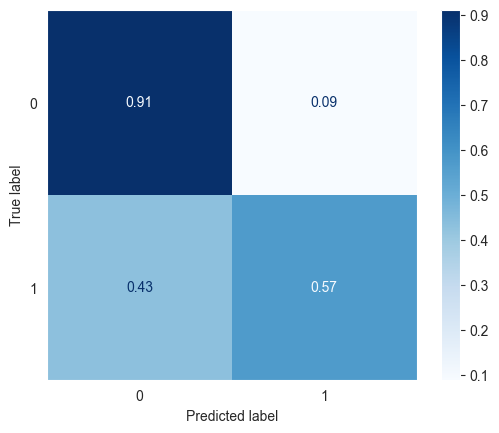

In [67]:
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels, normalize='true')
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels, normalize="true", cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [68]:
len(true_labels)

1648

In [69]:
accuracy_score(true_labels, pred_labels)

0.8185679611650486

In [70]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (2 * precision * recall)/ (precision+recall)
print("accuracy: ", accuracy_score(true_labels, pred_labels))
print("precision: ", precision) 
print("recall: ", recall)
print("f1: ", f1)

accuracy:  0.8185679611650486
precision:  0.8639906513427349
recall:  0.5698198198198198
f1:  0.6867281376107491


# Test on real data

In [71]:
df = pd.read_csv("../../preprocessing/data/processed_merge.csv", encoding='utf8', index_col=False).drop(['Unnamed: 0'], axis=1).dropna()

In [72]:
import re
df["preprocessed_text"]=[re.sub(r'[^\w\s]','',x) for x in df["preprocessed_text"]]
df["lens"] = [len(re.findall("[a-zA-Z_]+", x)) for x in df["preprocessed_text"]]

In [73]:
df

,Unnamed: 0.1,scenario,source_file,original_text,preprocessed_text,label,lens
0,0,Stroke,fridriksson08b.cha,well ‡ &=points:head yeah &=head:yes . 72423_...,well yeah,1,2
1,1,Cinderella,1030-1.cha,"and then she said +""/. 148717_150937",and then she said,1,4
2,2,Important_Event,capilouto59a.cha,sailors meaning we went on vacations where we ...,sailors meaning we went on vacations where we ...,0,11
3,3,Umbrella,richardson205.cha,but he insisted that it wasn't going to rain ....,but he insisted that it wasnt going to rain,0,9
4,4,Cinderella,UMD19.cha,and &-um the prince is dancing with all the yo...,and the prince is dancing with all the young l...,0,15
...,...,...,...,...,...,...,...
56314,56314,Cat,whiteside16a.cha,"+"" &=points:dog ruff@o ruff@o ! 337839_338849",ruff ruff,1,2
56315,56315,Stroke,wright206a.cha,thank_you &-uh all over again &=laughs . [+ gr...,thank you all over again,1,5
56316,56316,Stroke,50-2.cha,yes . 192554_193114,yes,1,1
56317,56317,Cinderella,wright11a.cha,"+"" well ‡ here's a coach for you to take you t...",well heres a coach for you to take you to the ...,0,12


In [74]:
df.to_csv("../../preprocessing/data/processed_merge_new.csv")

In [75]:
df = pd.concat([df[df["label"]==1].sample(n=1000),df[df["label"]==0].sample(n=1000)]).sample(frac=1)

In [76]:
import re
sentences = [re.sub(r'[^\w\s]','',x) for x in df["preprocessed_text"]]
labels = df["label"]

In [77]:
pred_labels_bert = []
true_labels = []

for sentence, label in zip(sentences, labels):
    if sentence is not None and isinstance(sentence, str):
        inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512).input_ids.to(device) 
        true_labels.append(label)
        with torch.no_grad():
            logits = model(inputs).logits
        predicted_class_id = logits.argmax().item()
        pred_labels_bert.append(predicted_class_id)

In [78]:
df["predicted"] = pred_labels_bert
df.to_csv("../../linguistic_model/data/answers.csv")

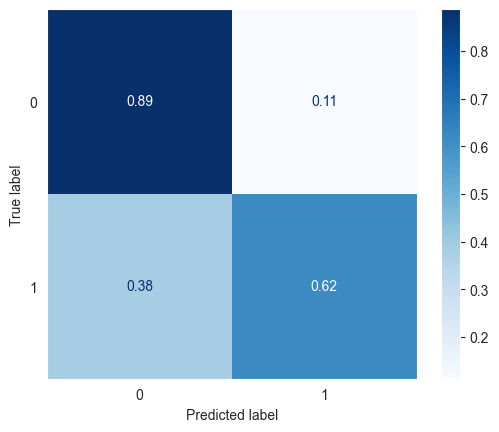

In [79]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels_bert, normalize='true')
tp, fp, fn, tn = cm.ravel()
ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels_bert, normalize="true", cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [80]:
metric = evaluate.load("accuracy")

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (2 * precision * recall)/ (precision+recall)
print("accuracy: ", accuracy_score(true_labels, pred_labels_bert))
print("precision: ", precision) 
print("recall: ", recall)
print("f1: ", f1)

accuracy:  0.753
precision:  0.888
recall:  0.6992125984251969
f1:  0.7823788546255506


# Feature visualization

In [81]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
# import torch
# 
# tokenizer = AutoTokenizer.from_pretrained(model_name, return_tensor="pt")
# model = AutoModel.from_pretrained(model_name)
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
# model = model.to(device)

In [82]:
# def extract_hidden_states(batch):
#     sentences = [x for x in batch["modified"]]
#     with torch.no_grad():
#         inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
#         last_hidden_state = model(inputs).last_hidden_state
# 
#     return {"hidden state": last_hidden_state[:, 0].cpu().numpy()}

In [83]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()

In [84]:
# hidden = tokenized_data_split.map(
#     extract_hidden_states, batched=True)

In [85]:
# hidden.save_to_disk('../models/bert_dataset_c4_reverse')

In [86]:
hidden["test"].column_names

NameError: name 'hidden' is not defined

In [ ]:
print(np.array(hidden["train"]["hidden state"]).shape)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

X_train = np.array(hidden["train"]["hidden state"])
y_train = np.array(hidden["train"]["label"])

X_test = np.array(hidden["test"]["hidden state"])
y_test = np.array(hidden["test"]["label"])

In [ ]:
# reduce to 2d for visualization
pca = PCA(n_components=2)

x_scaled = MinMaxScaler().fit_transform(X_train)
x_2d = pca.fit_transform(x_scaled)
x_2d.shape

x_scaled1 = MinMaxScaler().fit_transform(X_test)
x_2d1 = pca.fit_transform(x_scaled1)
x_2d1.shape

In [ ]:
# reduce to 3d for visualization
pca = PCA(n_components=3)

x_scaled = MinMaxScaler().fit_transform(X_train)
x_3d = pca.fit_transform(x_scaled)
x_3d.shape

x_scaled1 = MinMaxScaler().fit_transform(X_test)
x_3d1 = pca.fit_transform(x_scaled1)
x_3d1.shape

In [ ]:
# 2d viz
fig, ax = plt.subplots(2, 2, figsize=(7, 5))
ax = ax.flatten()
cmaps = ["blue", "orange"]
labels = set([x.item() for x in tokenized_data_split["train"]["label"]])

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_2d_sub = x_2d[y_train == i]
    ax[i].scatter(x_2d_sub[:, 0], x_2d_sub[:, 1], color=cmap)
    ax[i].set_title(id2label[label] +" TRAIN")
    
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_2d_sub1 = x_2d1[y_test == i]
    ax[i+2].scatter(x_2d_sub1[:, 0], x_2d_sub1[:, 1], color=cmap)
    ax[i+2].set_title(id2label[label] +" TEST" )

plt.tight_layout()
plt.show()

### Shows us that there might be an overlap in control text and broca text which indistinguishable to the model (so model goes with control as sort of default strategy)

In [ ]:
# 3d vis

fig, ax = plt.subplots(2, 2, subplot_kw={"projection": "3d"}, figsize=(8, 6))
ax = ax.flatten()
cmaps = ["blue", "orange"]
labels = set([x.item() for x in tokenized_data_split["train"]["label"]])

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_3d_sub = x_3d[y_train == i]
    ax[i].scatter(x_3d_sub[:, 0], x_3d_sub[:, 1], color=cmap)
    ax[i].set_title(id2label[label]+" TRAIN")
    
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_3d_sub1 = x_3d1[y_test == i]
    ax[i+2].scatter(x_3d_sub1[:, 0], x_3d_sub1[:, 1], color=cmap)
    ax[i+2].set_title(id2label[label]+" TEST" )

plt.tight_layout()
plt.show()

# Attention viz

In [ ]:
from bertviz import model_view, head_view
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained(model_name, return_tensor="pt")
model = AutoModel.from_pretrained(model_name)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

### For control sentence

In [ ]:
input = tokenizer.encode(sentences[0], return_tensors="pt")
output = model(input, output_attentions=True)

attention = output[-1]
tokens = tokenizer.convert_ids_to_tokens(input[0]) 
model_view(attention, tokens)
print(sentences[0], true_labels[0])

### For broca sentence

In [ ]:
input = tokenizer.encode(sentences[8], return_tensors="pt")
output = model(input, output_attentions=True)

attention = output[-1]
tokens = tokenizer.convert_ids_to_tokens(input[0]) 
model_view(attention, tokens)
print(sentences[8], true_labels[8])